#### Directories etc

In [79]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
from collections import defaultdict
import random
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import os
import copy
from Comparative_Analysis import ORF_Functions as orffn
from random import sample
pd.options.mode.chained_assignment = None  # default='warn'
import ete3
import matplotlib.pyplot as plt
from statistics import mode, median

In [80]:
project_dir = 'F:/Project_Data/Project_11'
seq_dir = 'F:/Datasets/Actinobacteria_Ref_Rep_Lev_Complete'
dictionary_dir = 'F:/Datasets/CRYPTIC_DATA/Cryptic_Dictionaries'
tb_species = 'NC_000962.3' 
tb_genome_filename = 'GCF_000195955.2_ASM19595v2_genomic.gbff'
mycobrowser_dir = 'F:/Datasets/Data_From_Publications'
num_cores = 16
core_numbers = list(range(1, num_cores+1))

In [3]:
with open(project_dir + '/Thoth_Full_Run/position_dict.pkl', 'rb') as f:
    full_sample_position_dict = pickle.load(f)   

In [4]:
for record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    full_sequence = str(record.seq)

In [5]:
with open(project_dir + '/Mutation_Counts/zero_and_non_zero_mutation_counts.pkl', 'rb') as f:
    zero_and_non_zero_mutation_counts = pickle.load(f)     
with open(project_dir + '/Thoth_Full_Run/zero_and_non_zero_mutation_counts.pkl', 'rb') as f:
    full_sample_zero_and_non_zero_mutation_counts = pickle.load(f)   

In [13]:
genomes_df = pd.read_csv('F:/Project_Data/Project_11/Datasets/GENOMES.csv');
lineage_dict = {}
for i,r in genomes_df.iterrows():
    lineage_dict[r['UNIQUEID']] = r['MYKROBE_LINEAGE_NAME_2'] 

C:\Users\nicho\AppData\Local\Temp/ipykernel_25824/2933718168.py:1: DtypeWarning: Columns (1,3,13,14,15,27,36) have mixed types. Specify dtype option on import or set low_memory=False.
  genomes_df = pd.read_csv('F:/Project_Data/Project_11/Datasets/GENOMES.csv');


In [14]:
compass_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/COMPASS.csv', names = ['species', 'start', 'stop','count'])
compass_dict = {}
for i, r in compass_df.iterrows():
    for k in range(r['start'], r['stop']):     #  Should te start-1 but seems to ve inconsistency with mutations!!
        compass_dict[k] = 'Y'

##### Plot p values for known CDS

In [15]:
annotation_cds_boundaries = []
for genome_record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    for feature in genome_record.features:
        if feature.type == 'CDS':
            a = feature.qualifiers  
            annotation_cds_boundaries.append((a.get("locus_tag")[0], a.get("product")[0], int(feature.location.start), int(feature.location.end), int(feature.location.strand)))   

In [44]:
mycobrowser_df = pd.read_excel(mycobrowser_dir+'/Mycobrowser_Release_4.xlsx')
temp_cds = mycobrowser_df[mycobrowser_df['Feature'] == 'CDS'][['Locus','Start','Stop','Strand','Product','Name']]      #Just CDS
mycobrowser_cds_boundaries = []
for i, r in temp_cds.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    mycobrowser_cds_boundaries.append((r['Locus'],r['Product'], r['Start']-1, r['Stop'], strand, r['Name']))
mycobrowser_cds_boundaries.sort(key = lambda x: x[2])

temp_cds = mycobrowser_df[mycobrowser_df['Feature'].isin(['CDS','rRNA','tRNA'])][['Locus','Start','Stop','Strand','Product','Name']]      #Just CDS
mycobrowser_all_boundaries = []
for i, r in temp_cds.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    mycobrowser_all_boundaries.append((r['Locus'],r['Product'], r['Start']-1, r['Stop'], strand, r['Name']))
mycobrowser_all_boundaries.sort(key = lambda x: x[2])

In [62]:
min_intergenic_length = 50
interregion_boundaries = []
max_stop = 0
for n,cds in enumerate(mycobrowser_all_boundaries):
    stop = cds[3]
    max_stop = max(stop, max_stop)
    if n < len(mycobrowser_all_boundaries) - 1:
        if mycobrowser_all_boundaries[n+1][2] > max_stop + min_intergenic_length:
            interregion_boundaries.append((cds[0], cds[1], max_stop, mycobrowser_all_boundaries[n+1][2], cds[4], cds[5]))


In [ ]:
min_intergenic_length = 50
candidate_intergenic_orfs = []
max_stop = 0
ORFFinder = orffn.ORF_Finder(full_sequence)
for n,cds in enumerate(mycobrowser_all_boundaries):
    stop = cds[3]
    max_stop = max(stop, max_stop)
    if n < len(mycobrowser_all_boundaries) - 1:
        if mycobrowser_all_boundaries[n+1][2] > max_stop + min_intergenic_length:
            a =ORFFinder.max_orf(max_stop, mycobrowser_all_boundaries[n+1][2], output_orfs = 'Nested', min_orf_length = 50)
            for x in a:
                candidate_intergenic_orfs.append(x)
            

In [39]:
def bin_formula(position_3_counts, tot_bin_counts):
    return 1- binom.cdf(position_3_counts-1, tot_bin_counts,1/3)
def mutation_bin_probability(mutation_counts):
    bin_counts = [0,0,0]
    for i, c in enumerate(mutation_counts):
        bin_counts[i % 3] += min(c,20)
    if sum(bin_counts) == 0:
        return (bin_counts, 2)
    else:
        return (bin_counts, bin_formula(bin_counts[2], sum(bin_counts)))  

In [173]:
p =sum([1 for x in full_sample_zero_and_non_zero_mutation_counts if x > 0])/(len(full_sequence) - len(compass_dict))
def conf_interval(n):
    return 4 * math.sqrt(p*(1-p))/math.sqrt(n)

In [227]:
locus_mutation_ave = []
scores =[]
for (locus, product, start, stop, strand, name) in mycobrowser_cds_boundaries: #interregion_boundaries:
    compass_overlap = 0
    for n in range(start, stop):
        if n in compass_dict:
            compass_overlap += 1
    if compass_overlap / (stop - start) > 0.1:
        continue
    mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:stop]
    if strand == 1:
        scores.append(mutation_bin_probability(mutation_counts)[1])
    else:
        scores.append(mutation_bin_probability(reversed(mutation_counts))[1])
    proportion_mutated_positions = sum([1 for m in mutation_counts if m>0])/len(mutation_counts)
    length = len(mutation_counts)
    if ((proportion_mutated_positions > p + conf_interval(length)) or (proportion_mutated_positions < p- conf_interval(length))):
        locus_class = 'X'
    else:
        locus_class = 'N'
    locus_mutation_ave.append([locus, name, product, sum(mutation_counts)/len(mutation_counts), max(mutation_counts), median(mutation_counts), start, stop, strand, 
                               len(mutation_counts), proportion_mutated_positions, locus_class])
locus_mutation_ave.sort(key = lambda x:x[3])

In [228]:
locus_mutation_ave_df = pd.DataFrame(locus_mutation_ave, columns = ['locus','name','product','ave_mutation','max_mutation','median_mutation','start','stop','strand',
                                                                    'length','ave_pos','locus_class'])

<AxesSubplot:xlabel='max_mutation', ylabel='ave_mutation'>

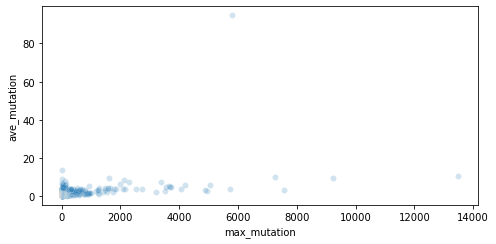

In [147]:
sns.scatterplot(data = locus_mutation_ave_df, y = 'ave_mutation', x ='max_mutation', alpha = 0.2)

<AxesSubplot:xlabel='length', ylabel='ave_pos'>

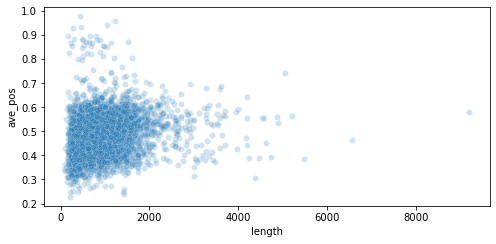

In [177]:
temp_df = locus_mutation_ave_df[locus_mutation_ave_df['ave_mutation'] <100000]
sns.scatterplot(data = temp_df, y = 'ave_pos', x ='length', alpha = 0.2)

<AxesSubplot:xlabel='length', ylabel='Count'>

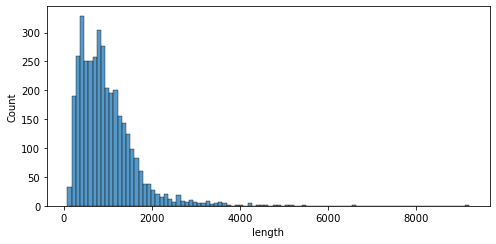

In [176]:
sns.histplot(temp_df['length'])

<AxesSubplot:xlabel='length', ylabel='Count'>

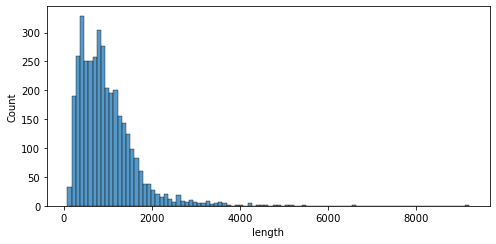

In [159]:
sns.histplot(locus_mutation_ave_df['length'])

<AxesSubplot:ylabel='Count'>

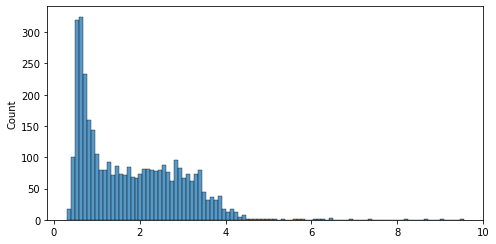

In [148]:
sns.histplot([x[3] for x in locus_mutation_ave if x[3] <10], bins=100)

<AxesSubplot:ylabel='Count'>

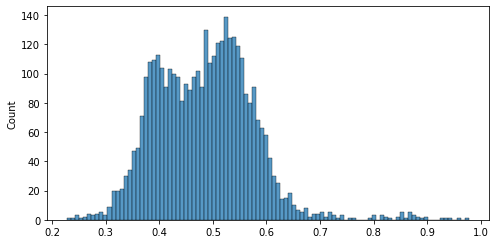

In [179]:
sns.histplot([x[10] for x in locus_mutation_ave], bins=100)

<AxesSubplot:ylabel='Count'>

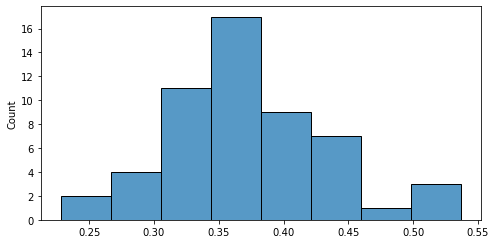

In [183]:
toxin_ave = []
for x in locus_mutation_ave:
    if 'antitoxin' in x[2]:
        toxin_ave.append(x[10])
sns.histplot(toxin_ave)

In [238]:
a=[x for x in locus_mutation_ave if x[10] < 0.33 and x[11] == 'X']
a.sort(key = lambda x: x[0])
for x in a:
    print(x)

['Rv0123', 'Rv0123', 'Unknown protein', 0.44986449864498645, 4, 0, 148855, 149224, 1, 369, 0.3143631436314363, 'X']
['Rv0300', 'vapB2', 'Possible antitoxin VapB2', 0.481981981981982, 4, 0.0, 363825, 364047, 1, 222, 0.32882882882882886, 'X']
['Rv0347', 'Rv0347', 'Probable conserved membrane protein', 0.3657548125633232, 12, 0, 417303, 418290, 1, 987, 0.2745694022289767, 'X']
['Rv0348', 'Rv0348', 'Possible transcriptional regulatory protein', 0.3929663608562691, 20, 0.0, 418292, 418946, 1, 654, 0.26605504587155965, 'X']
['Rv0354c', 'PPE7', 'PPE family protein PPE7', 0.45539906103286387, 12, 0.0, 424268, 424694, -1, 426, 0.323943661971831, 'X']
['Rv0394c', 'Rv0394c', 'Possible secreted protein', 0.4513888888888889, 6, 0.0, 474121, 474841, -1, 720, 0.3194444444444444, 'X']
['Rv0549c', 'vapC3', 'Possible toxin VapC3', 0.45893719806763283, 7, 0.0, 640227, 640641, -1, 414, 0.3285024154589372, 'X']
['Rv0596c', 'vapB4', 'Possible antitoxin VapB4', 0.5038759689922481, 12, 0.0, 695227, 695485, -1

<AxesSubplot:xlabel='ave_mutation', ylabel='ave_pos'>

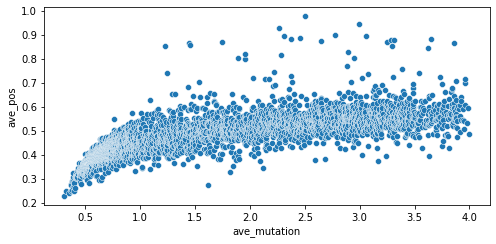

In [188]:
temp_df = locus_mutation_ave_df[locus_mutation_ave_df['ave_mutation'] <4]
sns.scatterplot(data = temp_df, x = 'ave_mutation', y = 'ave_pos')

<AxesSubplot:xlabel='length', ylabel='ave_pos'>

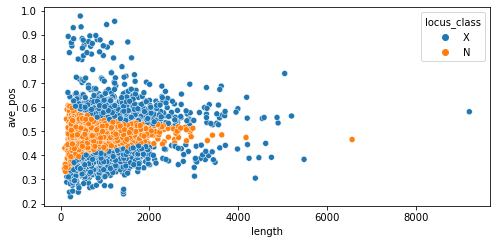

In [229]:
sns.scatterplot(data = locus_mutation_ave_df, x = 'length', y = 'ave_pos', hue = 'locus_class')

<AxesSubplot:xlabel='length', ylabel='proportion'>

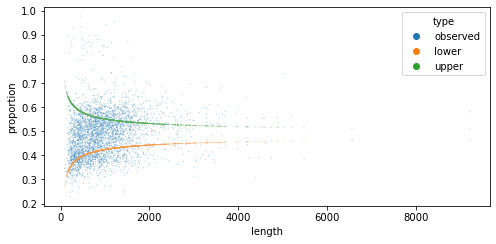

In [223]:
temp = []
for i, r in locus_mutation_ave_df.iterrows():
    temp.append([r['length'], r['ave_pos'],'observed'])
    temp.append([r['length'], p - conf_interval(r['length']), 'lower'])
    temp.append([r['length'], p + conf_interval(r['length']), 'upper'])
temp_df = pd.DataFrame(temp, columns = ['length','proportion','type'])
sns.scatterplot(data = temp_df, x = 'length', y = 'proportion', hue = 'type', s =1, alpha=0.5)

[Text(0.5, 0, 'P-value'), Text(0, 0.5, 'Count'), Text(0.5, 1.0, '')]

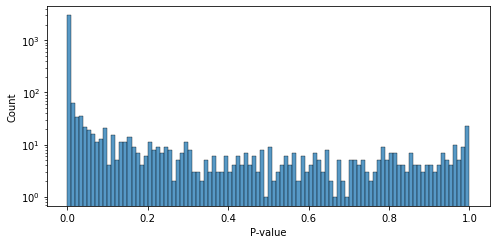

In [ ]:
plt=sns.histplot(scores, bins = 100, log_scale=(False,True))
#plt.yscale('log')
plt.set(xlabel ="P-value", ylabel = "Count", title ='')

[Text(0.5, 0, 'P-value'),
 Text(0, 0.5, 'Cumulative Proportion'),
 Text(0.5, 1.0, '')]

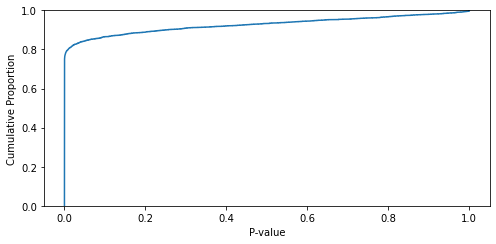

In [123]:
plt = sns.ecdfplot(scores)
plt.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')

In [26]:
filtered_intergenic_orfs = []
temp =[]
for (start, stop, strand, length) in candidate_intergenic_orfs:
    compass_overlap = 0
    for n in range(start, stop):
        if n in compass_dict:
            compass_overlap += 1
    if compass_overlap / (stop - start) > 0.2:
        continue
    if strand == 1:
        prob = mutation_bin_probability(full_sample_zero_and_non_zero_mutation_counts[start:stop])
    else:
        prob = mutation_bin_probability(reversed(full_sample_zero_and_non_zero_mutation_counts[start:stop]))
    temp.append(prob)
    if prob[1] < 0.01:
        filtered_intergenic_orfs.append((start, stop, strand, length, prob[1]))
scores = []
for x in temp:
    scores.append(x[1])

NameError: name 'candidate_intergenic_orfs' is not defined

In [ ]:
len(scores)

In [ ]:
sns.histplot(scores, bins = 100)

In [ ]:
filtered_intergenic_orfs[0:3]

#### Produce FASTA file with CDS candidates

In [ ]:
seq_dir = 'F:/Datasets/Actinobacteria_Ref_Rep_Lev_Complete'
sample_filenames = ['GCF_000195955.2_ASM19595v2_genomic.gbff', 'GCF_024600175.1_ASM2460017v1_genomic.gbff', 'GCF_010730055.1_ASM1073005v1_genomic.gbff', 'GCF_020616615.1_ASM2061661v1_genomic.gbff', 'GCF_010731535.1_ASM1073153v1_genomic.gbff',
                    'GCF_022370755.1_ASM2237075v1_genomic.gbff', 'GCF_016745295.1_ASM1674529v1_genomic.gbff', 'GCF_000157895.3_ASM15789v2_genomic.gbff', 'GCF_900603025.1_MHAS_genomic.gbff', 'GCF_018363015.1_ASM1836301v1_genomic.gbff',
                    'GCF_019645855.1_ASM1964585v1_genomic.gbff', 'GCF_010727945.1_ASM1072794v1_genomic.gbff', 'GCF_010731895.1_ASM1073189v1_genomic.gbff', 'GCF_900637205.1_50279_G01_genomic.gbff', 'GCF_000184435.1_ASM18443v1_genomic.gbff']
organism_name_dict = {}
for filename in tqdm(sample_filenames):
    record = next(SeqIO.parse(seq_dir + '/' + filename, "genbank"))
    organism_name = record.annotations['organism']
    accession_ver = record.annotations['accessions'][0] + '.' + str(record.annotations['sequence_version'])
    organism_name_dict[accession_ver] = organism_name

In [ ]:
trans = util.Translator()

In [ ]:
temp = []

for x in filtered_intergenic_orfs:
    prot = trans.translate_sequence(full_sequence[x[0]:x[1]], x[2], 0)
    name = 'NC_000962.3@'+str(x[0])+'_'+str(x[1])
    temp.append([name, prot[:-1]])
util.produce_fasta_file(temp, project_dir + '/filtered_intergenic_proteins.faa')

In [ ]:
#blastfn.build_blast_db(project_dir, 'comparator_orfs.fasta', 'comparator_orfs', 'F:/Datasets/BLAST/comparator_orfs')
#blastfn.build_blast_db(project_dir, 'mycobrowser_inter_feature_orfs.fasta', 'mycobrowser_inter_feature_orfs', 'F:/Datasets/BLAST/mycobrowser_inter_feature_orfs')

In [ ]:
blastfn.run_blastp('F:/Datasets/BLAST/comparator_orfs', 'filtered_intergenic_proteins.faa', 'comparator_orfs', 'filtered_intergenic_hits.csv', e_value = 0.001)

In [ ]:
blast_output = blastfn.process_blast_output('F:/Datasets/BLAST/comparator_orfs/filtered_intergenic_hits.csv', organism_name_dict, top_hit_only = False)

In [ ]:
blast_output.to_csv(project_dir + '/filtered_intergenic_blast_output.csv')

#### Look at mutation rate overdispersion

In [ ]:
trans.translate_sequence(full_sequence[2405354:2405486],-1,0)

In [11]:
mutation_bin_probability(reversed(full_sample_zero_and_non_zero_mutation_counts[908014:908113]))
#mutation_bin_probability((full_sample_zero_and_non_zero_mutation_counts[1232176:1232293]))

([93, 40, 155], 7.390754674929667e-13)

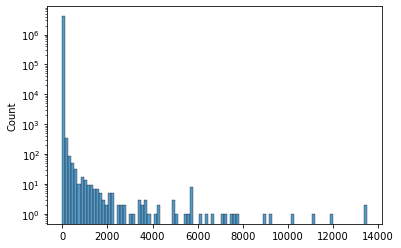

In [78]:
amended_mutation_counts = []
for n, c in enumerate(full_sample_zero_and_non_zero_mutation_counts):
    if n in compass_dict:
        continue
    else:
        amended_mutation_counts.append(c)
pd.DataFrame(amended_mutation_counts).to_csv(project_dir + '/R_amended_mutation_counts.csv')
sns.histplot([x for x in amended_mutation_counts], bins = 100)
plt.yscale('log')

In [ ]:
for n, c in enumerate(full_sample_zero_and_non_zero_mutation_counts):
    if c>8000 and c< 100000:
        position_info = full_sample_position_dict[n+1]
        substitutions = [x[1] for x in position_info[1:]]
        source = full_sequence[n-1:n+2]
        destination = full_sequence[n-1] + mode(substitutions).upper() + full_sequence[n+1]
        print(n, c, full_sequence[n-1:n+2], position_info[0], mode(substitutions), source, destination)

In [ ]:
len(full_sample_position_dict[836538])

In [ ]:
np.random.poisson(50, 1)[0]

In [ ]:
temp=[]
gfg = np.random.gamma(0.0001, 3000, 4000000)
for x in gfg:
    temp.append(np.random.poisson(x, 1)[0])
sns.histplot([x for x in temp] , bins=100)
plt.yscale('log')

In [ ]:
temp = []
for n, c in enumerate(zero_and_non_zero_mutation_counts):
    if n in compass_dict:
        temp.append(c)
pd.DataFrame(temp).to_csv(project_dir + '/R_amended_mutation_counts.csv')

In [ ]:
for k, v in compass_dict.items():
    if not(full_sample_zero_and_non_zero_mutation_counts[k] ==0):
        print(k, full_sample_zero_and_non_zero_mutation_counts[k])

In [ ]:
pd.DataFrame(full_sample_zero_and_non_zero_mutation_counts).to_csv(project_dir + '/R_mutation_counts.csv')

#####  Tree mutation plots for output displays in R

In [ ]:
with open(project_dir + '/Dictionaries/variant_dictionary_364848_365376_.pkl', 'rb') as f:
        var_dict = pickle.load(f)  
with open(project_dir + '/Mutation_Counts/mutation_counts_364848_365376_.pkl', 'rb') as f:
        mutation_counts = pickle.load(f)  
temp_dict = {}
for k, v in var_dict.items():
    if not(v[pos_id_dict[3186859] - 364848] =={'T'}):
        temp_dict[k] =list(v[pos_id_dict[3186859] - 364848])[0]

In [ ]:
with open(project_dir + '/Dictionaries/variant_dictionary_331584_332112_.pkl', 'rb') as f:
        var_dict = pickle.load(f)  
with open(project_dir + '/Mutation_Counts/mutation_counts_331584_332112_.pkl', 'rb') as f:
        mutation_counts = pickle.load(f)  
temp_dict = {}
for k, v in var_dict.items():
    if not(v[pos_id_dict[2878549] - 331584] =={'G'}):
        temp_dict[k] =list(v[pos_id_dict[2878549] - 331584])[0]

In [ ]:
tb_tree_filename = 'tb_gpi.nwk'
master_tree2= ete3.Tree(project_dir + '/' + tb_tree_filename)
for node in master_tree2.traverse("postorder"):
    if node.is_leaf():
        if node.name in temp_dict:
            node.name = str(lineage_dict[id_reverse_dict[int(node.name.split('_')[1])]]) + '_'+temp_dict[(node.name)]
            nstyle = ete3.NodeStyle()
            nstyle["fgcolor"] = "red"
            nstyle["size"] = 1
            node.set_style(nstyle)
        else:
            node.name = str(lineage_dict[id_reverse_dict[int(node.name.split('_')[1])]])

In [ ]:
master_tree2.render(project_dir+'/mytree.pdf', tree_style=ts);

In [ ]:
tb_tree_filename = 'tb_gpi.nwk'
master_tree2= ete3.Tree(project_dir + '/' + tb_tree_filename)
temp = []
for node in master_tree2.traverse("postorder"):
    if node.is_leaf():
        temp.append([node.name, lineage_dict[id_reverse_dict[int(node.name.split('_')[1])]]])
temp_df = pd.DataFrame(temp, columns = [['label', 'lineage']])
temp_df.to_csv(project_dir + '/lineages.csv')

In [ ]:
for k, v in position_dict.items():
    #if len(v) > 5000 and len(v) < 10000:
    if 1==1:
        if  zero_and_non_zero_mutation_counts[k-1] > 1000  and zero_and_non_zero_mutation_counts[k-1]/(len(v)-1) > 0.1:
            print(k-1, pos_id_dict[k-1], len(v)-1,  zero_and_non_zero_mutation_counts[k-1], zero_and_non_zero_mutation_counts[k-1]/(len(v)-1), full_sequence[k-1], v[0], set([x[1] for x in v[1:]]) )

In [ ]:
for n, x in enumerate(zero_and_non_zero_mutation_counts):
    if x > 0 and len(variant_df[variant_df['GENOME_INDEX'] == n+1]) ==  0:
        print(n, pos_id_dict[n], x, len(variant_df[variant_df['GENOME_INDEX'] == n+1]), n, x/len(variant_df[variant_df['GENOME_INDEX'] == n+1]))
        